In [1]:
import pandas as pd
import numpy as np
import math
import glob
import scipy
from scipy.optimize import basinhopping
from scipy.optimize import minimize
import scipy.optimize as op
import scipy.stats as stats
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf
%matplotlib inline

In [2]:
# get list of data files to process
data_files = glob.glob('data/*txt')

In [3]:
# CONSTANTS NECESSARY FOR MAKING SENSE OF THE DATA FILES
col_names = ['stim', 'cond', 'trial', 'amountSS',
             'amountLL', 'delayLL', 'choice', 'space','pct_diff']
stim = { 1:'Pre', 2:'TMS', 3:'Sham' }
cond = { 1:'Ctrl', 2:'Hidden Zero', 3:'Magnitude' }
choice = { 1:'SS', 0:'LL'}

In [33]:
all_data = []
for f in data_files:
    data = pd.read_csv(f, delimiter = '\t', header = None,
                      names = col_names, index_col = False)
    
    data['choice_binary'] = data['choice']
    data['choice'] = [choice[x] for x in data['choice']]
    data['cond'] = [cond[x] for x in data['cond']]
    data['stim'] = [stim[x] for x in data['stim']]
    
    data = data[['stim', 'cond', 'trial', 'amountSS', 
                 'amountLL', 'delayLL', 'choice','choice_binary','pct_diff']]
    
    data['hemi'] = f.split('/')[1].split('s')[0]
    data['sub'] = f.split('.')[0][-2:]
     
    all_data.append(data)
all_data = pd.concat(all_data)

In [34]:
def find_K(A1,A2,d1,d2):
    return (A2/A1 - 1)*1.0 / (d2 - (A2/A1)*d1)

In [35]:
#find k_eq for each choice
for row in set(all_data.index):
    k_eq = find_K(all_data.loc[row,'amountSS'].values[0],
       all_data.loc[row,'amountLL'].values[0],
       0,
       all_data.loc[row,'delayLL'].values[0])
    

    all_data.loc[row,'k_eq'] = k_eq

#drop trial level
all_data = all_data.reset_index().set_index(['sub','cond','stim','hemi']).sort_index()

In [36]:
def hyperbolic(A,d,k):
    return A * 1.0/(1.0+k*d)

In [37]:
def errf(params,sub_data):
    #get params and bound on [0,1]
    k,m = params
    k = scipy.stats.logistic.cdf(k)
    m = scipy.stats.logistic.cdf(m)*20
    LL = 0
    for trial in range(sub_data.shape[0]):
        SV_SS = hyperbolic(sub_data.loc[trial,'amountSS'],
                            0, #delayed rewards available now
                            k)
        SV_LL = hyperbolic(sub_data.loc[trial,'amountLL'],
                            sub_data.loc[trial,'delayLL'],
                            k)

        p = 1 / (1 + np.exp(-1*(SV_SS-SV_LL)*m) )
        if sub_data.loc[trial,'choice'] == 'LL':
            p = 1-p
            
        if p < 1e-100:
            p = 1e-100
            
        LL += np.log(p)
    return LL*-1 #minimize negative log likelihood

In [9]:
in_tuples = list(set(all_data.index))

In [50]:
def run_data(in_tup):
    #get the data for this experiment
    sub_data = all_data.loc[in_tup].reset_index().copy()
    
    #check to see if they made all LL or all SS choices and set k appropriately
    if sum(sub_data['choice'] == 'LL') == sub_data.shape[0]: #all larger later
        k = min(sub_data['k_eq'])
        return in_tup,k
    elif sum(sub_data['choice'] == 'SS') == sub_data.shape[0]: #all SS
        k = max(sub_data['k_eq'])
        return in_tup,k
    
    #run minimization
    else:
        k_init = scipy.stats.logistic.ppf(sub_data['k_eq'].mean())
        params = [k_init,-2]
        minimizer_kwargs = {"method": 'CG', 'args':(sub_data)}
        try:
            res = basinhopping(errf, params, minimizer_kwargs=minimizer_kwargs,niter=50)
        except:
            return (in_tup,'Failed')
        return (in_tup,res)

In [ ]:
pool = multiprocessing.Pool(54)
res = pool.map(run_data,in_tuples)
pool.terminate()
pool.join()

In [14]:
results_df = {'ll':[], 'k':[], 'm':[],'sub':[],'exp':[],'hemi':[],'tms':[]}
for x in res:
    in_tup,o = x
    sub, exp, tms, hemi = in_tup
    if o == 'Failed':
        print in_tup
        
    else:
        results_df['ll'].append(o.fun*-1)
        results_df['k'].append(scipy.stats.logistic.cdf(o.x[0]))
        results_df['m'].append(scipy.stats.logistic.cdf(o.x[1])*20)
        results_df['sub'].append(sub)
        results_df['exp'].append(exp)
        results_df['tms'].append(tms)
        results_df['hemi'].append(hemi)
results_df = pd.DataFrame(results_df)
results_df = results_df.set_index(['sub','exp','tms','hemi'])

In [16]:
#compute LLRT relative to to coin flip model
for in_tup in in_tuples:
    sub_data = all_data.loc[in_tup].reset_index().copy()
    
    null_ll = np.log(.5)*sub_data.shape[0]
    ll = results_df.loc[in_tup,'ll']
    ratio = 2*(ll - null_ll)
    test_stat = stats.chi2.sf(ratio,2)
    
    results_df.loc[in_tup,'chi'] = test_stat

/home/iballard/.local/lib/python2.7/site-packages/pandas/core/index.py:4307: PerformanceWarning: indexing past lexsort depth may impact performance.
  PerformanceWarning)


In [18]:
#log transform k
results_df = results_df.reset_index()
results_df['logk'] = np.log(results_df['k'])

In [19]:
#average over hemispheres
r = results_df.groupby(['exp','tms','sub']).mean().reset_index()

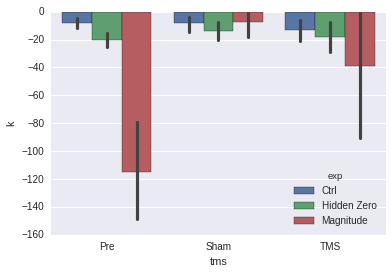

In [21]:
sns.barplot(x = 'tms', y = 'logk',hue = 'exp' , data = r)
plt.ylabel('k')

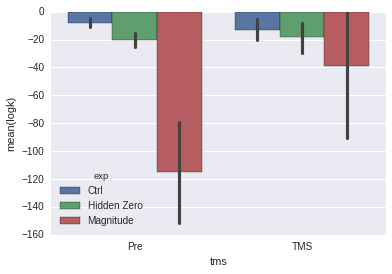

In [22]:
pre = r[r['tms'] !='Sham']
test = pre[pre['exp'] != '']
sns.barplot(x = 'tms', y = 'logk',hue = 'exp' , data = test)


In [173]:
results_df = results_df.set_index(['sub','exp','tms','hemi'])

# Percent SS Analysis

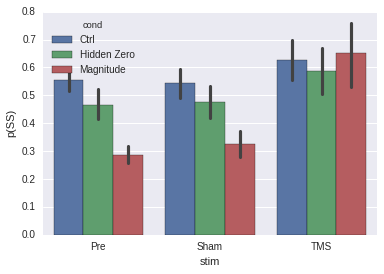

In [45]:
perc_df =all_data.reset_index().groupby(['sub','stim','cond']).mean().reset_index()
sns.barplot(x = 'stim', y = 'choice_binary',hue = 'cond' , data = perc_df)
plt.ylabel('p(SS)')

In [46]:
model_str = 'choice_binary ~ stim*cond'
mixedfx = smf.mixedlm(model_str, perc_df, groups = perc_df['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      choice_binary
No. Observations:       135          Method:                  REML         
No. Groups:             15           Scale:                   0.0134       
Min. group size:        9            Likelihood:              70.9916      
Max. group size:        9            Converged:               Yes          
Mean group size:        9.0                                                
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.556    0.034 16.121 0.000  0.488  0.623
stim[T.Sham]                     -0.011    0.042 -0.254 0.800 -0.094  0.072
stim[T.TMS]                       0.071    0.042  1.677 0.094 -0.012  0.154
cond[T.Hidden Zero]            

/home/iballard/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
